In [2]:
package Context {
    doc /* 
         *  This package contains the contextual elements of the system,
         *  such as outward facing interfaces & ports.
         */
        
    package 'Abstract system interface' {
        port def 'Chassis Port' {
            in acceleration: 'Environment information'::Acceleration;
        }
        port def 'Driver Port' {
            in command: 'Environment information'::'Driver command';
        }
        port def 'Traffic Port' {
            in traffic: 'Environment information'::'Traffic arrangement';
        }
        port def 'Wheel Port' {
            in speed: 'Environment information'::'Rotation speed'[4];
            out torque: 'Environment information'::Torque;
        }
    }
    package 'Environment information' {
        part def Acceleration;
        part def 'Driver command';
        part def 'Rotation speed';
        part def Torque;
        part def 'Traffic arrangement';
    }
    part def 'Adaptive Cruise Control System' {
        inout port 'wheel port': 'Abstract system interface'::'Wheel Port';
        in port 'driver port': 'Abstract system interface'::'Driver Port';
        in port 'traffic port': 'Abstract system interface'::'Traffic Port';
        in port 'chassis port': 'Abstract system interface'::'Chassis Port';
    }

    part 'System Context' {
        part wheels[4];
        part driver;
        part traffic;
        part chassis;
        part system : 'Adaptive Cruise Control System';
        flow of 'Environment information'::Acceleration 
            from chassis.self
            to system.'chassis port';
        flow of 'Environment information'::Torque 
            from system.'wheel port'
            to wheels.self;
        flow of 'Environment information'::'Driver command' 
            from driver.self
            to system.'driver port';
        flow of 'Environment information'::'Rotation speed' 
            from wheels.self
            to system.'wheel port';
        flow of 'Environment information'::'Traffic arrangement' 
            from traffic.self
            to system.'traffic port';
    }
}

Package Context (0e924bbc-5a91-4a19-9415-fb0e97a19ac6)


In [5]:
package 'Functional model' {
    doc /* 
         *  This package contains the abstract functional elements of the system.
         */
    
    part def Functional; // all functional parts are descendants of the Functional part def
        
    package Signals {
        item def SetSpeed {
            attribute value: ScalarValues::Integer;
        }
        item def TurnOff;
        item def DecreaseSpeed;
        item def HoldSpeed;
        item def IncreaseSpeed;
        item def CurrentSpeed {
            attribute value :> ISQ::speed;
        }
        item def CurrentDistance {
            attribute value :> ISQ::length;
        }
    }

    package Interfaces {
        port def 'Command Port' {
            in item setSpeed: Signals::SetSpeed;
            in item turnOff: Signals::TurnOff;
        }
        port def 'Distance Sensor Port' {
            in item currentDistance: Signals::CurrentDistance;
        }
        port def 'Engine Port' {
            in item decreaseSpeed: Signals::DecreaseSpeed;
            in item holdSpeed: Signals::HoldSpeed;
            in item increaseSpeed: Signals::IncreaseSpeed;
        }
        port def 'Speed Sensor Port' {
            in item currentSpeed: Signals::CurrentSpeed;
        }
        

        interface def 'Command Interface' {
            end supplierPort : ~'Command Port';
            end consumerPort : 'Command Port';
        }
        interface def 'Distance Interface' {
            end supplierPort : ~'Distance Sensor Port';
            end consumerPort : 'Distance Sensor Port';
        }
        interface def 'Engine Interface' {
            end supplierPort : ~'Engine Port';
            end consumerPort : 'Engine Port';
        }
        interface def 'Speed Interface' {
            end supplierPort : ~'Speed Sensor Port';
            end consumerPort : 'Speed Sensor Port';
        }
    }


    package Functions {
        part def 'ACC Commander' :> Functional {
            port cmd: ~Interfaces::'Command Port';
        }
        part def 'Distance Sensor' :> Functional {
            port ds: ~Interfaces::'Distance Sensor Port';
            part 'Calculate distance from laser sensor' : Functional;
            part 'Calculate distance from infrared sensor' : Functional;
            part 'Determine distance' : Functional;
        }
        part def 'Engine Controller' :> Functional {
            port ec: Interfaces::'Engine Port';
        }
        part def 'Speed Sensor' :> Functional {
            port ss: ~Interfaces::'Speed Sensor Port';
            part 'Count rotations'[4] : Functional;
            part 'Aggregate rotation into speed' : Functional;
            part 'Calculate speed from forces' : Functional;
            part 'Determine speed' : Functional;
        }
        part def 'AC Control' :> Functional {
            ref part distanceSensor: 'Distance Sensor' [1..*];
            ref part speedSensor: 'Speed Sensor' [1..*];
            ref part engineController: 'Engine Controller' [1];
            ref part commander: 'ACC Commander' [1];

            attribute accSpeed :> ISQ::speed;
            attribute lastSpeed :> ISQ::speed;
            attribute lastDistance :> ISQ::length;
            attribute distanceThreshold :> ISQ::length;

            port ec: ~Interfaces::'Engine Port';
            port ds: Interfaces::'Distance Sensor Port';
            port ss: Interfaces::'Speed Sensor Port';
            port cmd: Interfaces::'Command Port';
            
            part 'Calculate engine command'[2] : Functional;
            part 'Compare engine command' : Functional;
        }
        
    }

    part def 'Adaptive Cruise Control Function' :> Context::'Adaptive Cruise Control System', Functional {
        part acc : Functions::'AC Control';
        part cmd : Functions::'ACC Commander';
        part ds : Functions::'Distance Sensor';
        part ec : Functions::'Engine Controller';
        part ss : Functions::'Speed Sensor';

        interface : Interfaces::'Distance Interface' connect
            supplierPort :> ds.ds to
            consumerPort :> acc.ds;            
        interface : Interfaces::'Speed Interface' connect
            supplierPort :> ss.ss to
            consumerPort :> acc.ss;            
        interface : Interfaces::'Command Interface' connect
            supplierPort :> cmd.cmd to
            consumerPort :> acc.cmd;            
        interface : Interfaces::'Engine Interface' connect
            supplierPort :> ec.ec to
            consumerPort :> acc.ec;

        flow of Context::'Environment information'::'Rotation speed' 
            from self.'wheel port'
            to ss.self;
        flow of Context::'Environment information'::Acceleration 
            from self.'chassis port'
            to ss.self;
        flow of Context::'Environment information'::'Traffic arrangement' 
            from self.'traffic port'
            to ds.self;
        flow of Context::'Environment information'::'Driver command' 
            from self.'driver port'
            to cmd.self;
        flow of Context::'Environment information'::Acceleration 
            from ec.self
            to self.'wheel port';
    }
}

Package Functional model (6c1fcbaf-b5f8-4e5a-a318-ffcbfd17eaaa)


In [7]:
package 'Platform model' {
    doc /* 
         *  This package contains the platform (hardware) elements of the system.
         */
        
    part def Platform;
    
    package Signals {
        item def Wireable;
        item def GND :> Wireable;
        item def Rail_5V :> Wireable;
        item def Rail_3_3V :> Wireable;
        item def Rail_11_1V :> Wireable;
        
        attribute def DigitalValue :> ScalarValues::Boolean, Wireable;
        
        attribute def SensorValue :> ScalarValues::Real;
        
        attribute def DerivedValue {
            attribute timestamp: ScalarValues::Integer;
            attribute payload: SensorValue;
        }
    }
        
    package Interfaces {
        port def WireablePort {
            inout wireable: Signals::Wireable;
        }
        port def Power_5V_Port {
            in v: Signals::Rail_5V; 
        }
        port def Power_3_3V_Port {
            in v: Signals::Rail_3_3V; 
        }
        port def Power_11_1V_Port {
            in v: Signals::Rail_11_1V; 
        }
        port def Power_GND_Port {
            in gnd: Signals::GND;
        }
        port def DigitalPort {
            out value: Signals::DigitalValue;
        }
        port def SensorPort {
            out value: Signals::SensorValue;
        }
        port def DerivedPort {
            out value: Signals::DerivedValue;
        }
        
        interface def Wire {
            end a: WireablePort;
            end b: WireablePort;
        }
        
        interface def Transform_11_1V_to_5V {
            end source: ~Power_11_1V_Port;
            end output: Power_5V_Port;
            
            flow from source.v to output.v;
        }
        interface def Transform_11_1V_to_3_3V {
            end source: ~Power_11_1V_Port;
            end output: Power_3_3V_Port;
            
            flow from source.v to output.v;
        }
        
        interface def DigitalValueInterface {
            end source: DigitalPort;
            end target: ~DigitalPort;
            
            flow from source.value to target.value;
        }
        interface def SensorValueInterface {
            end source: SensorPort;
            end target: ~SensorPort;
            
            flow from source.value to target.value;
        }
        interface def DerivedValueInterface {
            end source: DerivedPort;
            end target: ~DerivedPort;
            
            flow from source.value to target.value;
        }
    }
    
    package Components {
        package Hardware {
            part def Resistor :> Platform  {
                inout port a: Interfaces::WireablePort;
                inout port b: Interfaces::WireablePort;
                
                attribute resistance: ScalarValues::Real; 
            }
            part def Capacitor :> Platform  {
                inout port a: Interfaces::WireablePort;
                inout port b: Interfaces::WireablePort;
                
                attribute capacitance: ScalarValues::Real;
            }
            part def LED :> Platform  {
                in port anode: Interfaces::WireablePort;
                out port cathode: Interfaces::WireablePort;
            }
            part def ButtonAssembly :> Platform  {
                doc /* 
                     *  The resistor is limiting the current of the VCC pin of the power connection
                     */
                in port v: Interfaces::Power_5V_Port;
                in port g: Interfaces::Power_GND_Port;
                out port s: Interfaces::DigitalPort;
                
                part res: Resistor;
                part btn {
                    in port i: Interfaces::WireablePort;
                    out port o: Interfaces::WireablePort;
                }
                
                interface: Interfaces::Wire connect v to res.a;
                interface: Interfaces::Wire connect res.b to btn.o;
                interface: Interfaces::Wire connect btn.o to s;
                interface: Interfaces::Wire connect g to btn.i;
            }
            part def EncoderAssembly :> Platform  {
                doc /* 
                     *  The resistors are limiting the current of the VCC pin of the power connections
                     */
                in port v1: Interfaces::Power_5V_Port;
                in port v2: Interfaces::Power_5V_Port;
                in port g: Interfaces::Power_GND_Port;
                out port s1: Interfaces::DigitalPort;
                out port s2: Interfaces::DigitalPort;
                
                part res1: Resistor;
                part res2: Resistor;
                part enc {
                    in port g: Interfaces::WireablePort;
                    out port o1: Interfaces::WireablePort;
                    out port o2: Interfaces::WireablePort;
                }
                
                interface: Interfaces::Wire connect v1 to res1.a;
                interface: Interfaces::Wire connect v2 to res2.a;
                interface: Interfaces::Wire connect res1.b to enc.o1;
                interface: Interfaces::Wire connect res2.b to enc.o2;
                interface: Interfaces::Wire connect enc.o1 to s1;
                interface: Interfaces::Wire connect enc.o2 to s2;
                interface: Interfaces::Wire connect g to enc.g;  
            }
            part def NineDOFSensor :> Platform  {
                in port vcc: Interfaces::Power_5V_Port;
                in port gnd: Interfaces::Power_GND_Port;
                inout port scl: Interfaces::WireablePort;
                inout port sda: Interfaces::WireablePort;
                inout port xcl: Interfaces::WireablePort;
                inout port xda: Interfaces::WireablePort;
                inout port ado: Interfaces::WireablePort;
                inout port int: Interfaces::WireablePort;
            }
            part def InfraredSensor :> Platform  {
                in port vcc: Interfaces::Power_5V_Port;
                in port gnd: Interfaces::Power_GND_Port;
                out port s: Interfaces::SensorPort;
            }
            part def LaserSensor :> Platform  {
                in port vcc: Interfaces::Power_5V_Port;
                in port gnd: Interfaces::Power_GND_Port;
                inout port tx: Interfaces::WireablePort;
                inout port rx: Interfaces::WireablePort;
                inout port scl: Interfaces::WireablePort;
                inout port sda: Interfaces::WireablePort;
                inout port gpio1: Interfaces::WireablePort;
                inout port xshut: Interfaces::WireablePort;
                inout port pwm: Interfaces::WireablePort;
                inout port ps: Interfaces::WireablePort;
            }
            part def A4988 :> Platform  {
                in port vcc: Interfaces::Power_11_1V_Port;
                in port vdd: Interfaces::Power_5V_Port;
                in port gnd: Interfaces::Power_GND_Port;
                in port ms1: Interfaces::DigitalPort;
                in port ms2: Interfaces::DigitalPort;
                in port ms3: Interfaces::DigitalPort;
                in port stp: Interfaces::DigitalPort;
                in port dir: Interfaces::DigitalPort;
                out port _1A: Interfaces::WireablePort;
                out port _1B: Interfaces::WireablePort;
                out port _2A: Interfaces::WireablePort;
                out port _2B: Interfaces::WireablePort;
            }
            part def ATTiny85 :> Platform  {
                inout port p1: Interfaces::WireablePort;
                inout port p2: Interfaces::WireablePort;
                inout port p3: Interfaces::WireablePort;
                inout port p4: Interfaces::WireablePort;
                inout port p5: Interfaces::WireablePort;
                inout port p6: Interfaces::WireablePort;
                inout port p7: Interfaces::WireablePort;
                inout port p8: Interfaces::WireablePort;
            }
            part def ATmega328p :> Platform  {
                inout port p1: Interfaces::WireablePort;
                inout port p2: Interfaces::WireablePort;
                inout port p3: Interfaces::WireablePort;
                inout port p4: Interfaces::WireablePort;
                inout port p5: Interfaces::WireablePort;
                inout port p6: Interfaces::WireablePort;
                inout port p7: Interfaces::WireablePort;
                inout port p8: Interfaces::WireablePort;
                inout port p9: Interfaces::WireablePort;
                inout port p10: Interfaces::WireablePort;
                inout port p11: Interfaces::WireablePort;
                inout port p12: Interfaces::WireablePort;
                inout port p13: Interfaces::WireablePort;
                inout port p14: Interfaces::WireablePort;
                inout port p15: Interfaces::WireablePort;
                inout port p16: Interfaces::WireablePort;
                inout port p17: Interfaces::WireablePort;
                inout port p18: Interfaces::WireablePort;
                inout port p19: Interfaces::WireablePort;
                inout port p20: Interfaces::WireablePort;
                inout port p21: Interfaces::WireablePort;
                inout port p22: Interfaces::WireablePort;
                inout port p23: Interfaces::WireablePort;
                inout port p24: Interfaces::WireablePort;
                inout port p25: Interfaces::WireablePort;
                inout port p26: Interfaces::WireablePort;
                inout port p27: Interfaces::WireablePort;
                inout port p28: Interfaces::WireablePort;
            }
            part def ESPWroom32 :> Platform  {
                inout port wlan: Interfaces::DerivedPort;
                inout port p1: Interfaces::WireablePort;
                inout port p2: Interfaces::WireablePort;
                inout port p3: Interfaces::WireablePort;
                inout port p4: Interfaces::WireablePort;
                inout port p5: Interfaces::WireablePort;
                inout port p6: Interfaces::WireablePort;
                inout port p7: Interfaces::WireablePort;
                inout port p8: Interfaces::WireablePort;
                inout port p9: Interfaces::WireablePort;
                inout port p10: Interfaces::WireablePort;
                inout port p11: Interfaces::WireablePort;
                inout port p12: Interfaces::WireablePort;
                inout port p13: Interfaces::WireablePort;
                inout port p14: Interfaces::WireablePort;
                inout port p15: Interfaces::WireablePort;
                inout port p16: Interfaces::WireablePort;
                inout port p17: Interfaces::WireablePort;
                inout port p18: Interfaces::WireablePort;
                inout port p19: Interfaces::WireablePort;
                inout port p20: Interfaces::WireablePort;
                inout port p21: Interfaces::WireablePort;
                inout port p22: Interfaces::WireablePort;
                inout port p23: Interfaces::WireablePort;
                inout port p24: Interfaces::WireablePort;
                inout port p25: Interfaces::WireablePort;
                inout port p26: Interfaces::WireablePort;
                inout port p27: Interfaces::WireablePort;
                inout port p28: Interfaces::WireablePort;
                inout port p29: Interfaces::WireablePort;
                inout port p30: Interfaces::WireablePort;
                inout port p31: Interfaces::WireablePort;
                inout port p32: Interfaces::WireablePort;
                inout port p33: Interfaces::WireablePort;
                inout port p34: Interfaces::WireablePort;
                inout port p35: Interfaces::WireablePort;
                inout port p36: Interfaces::WireablePort;
                inout port p37: Interfaces::WireablePort;
                inout port p38: Interfaces::WireablePort;
            }
        }
        
        part def RotationSensor :> Platform {
            out port rs: Interfaces::SensorPort;
            
            part enc: Hardware::EncoderAssembly;
            part mcu: Hardware::ATTiny85;
            part c  : Hardware::Capacitor;
            part btn: Hardware::ButtonAssembly;
            part led: Hardware::LED;
        }
        part def MultiRotationSensor :> Platform { 
            out port rs: Interfaces::SensorPort;
            out port err: Interfaces::DigitalPort;
            
            part sensors[4]: RotationSensor;        
            part mcu: Hardware::ATmega328p;
            
            interface: Interfaces::Wire connect sensors.rs[0] to mcu.p11;
            interface: Interfaces::Wire connect sensors.rs[1] to mcu.p12;
            interface: Interfaces::Wire connect sensors.rs[2] to mcu.p13;
            interface: Interfaces::Wire connect sensors.rs[3] to mcu.p14;
        }
        part def AccelerationSensor :> Platform {
            out port acc: Interfaces::SensorPort;
            out port err: Interfaces::DigitalPort;
            
            part sensor: Hardware::NineDOFSensor;
            part mcu: Hardware::ATmega328p;
            
            interface: Interfaces::Wire connect sensor.scl to mcu.p28;
            interface: Interfaces::Wire connect sensor.sda to mcu.p27;
        }
        part def DistanceSensor :> Platform  {
            out port dst: Interfaces::SensorPort;
            out port err: Interfaces::DigitalPort;
            
            part laser: Hardware::LaserSensor;
            part infrared: Hardware::InfraredSensor;
            part mcu: Hardware::ATmega328p;
            
            interface: Interfaces::Wire connect laser.scl to mcu.p28;
            interface: Interfaces::Wire connect laser.sda to mcu.p27;
            interface: Interfaces::Wire connect infrared.s to mcu.p26;
        }
        part def EngineControl :> Platform  {
            out port enginePort {
                out port _1A: Interfaces::WireablePort;
                out port _1B: Interfaces::WireablePort;
                out port _2A: Interfaces::WireablePort;
                out port _2B: Interfaces::WireablePort;
            }
            in port cmd: Interfaces::DerivedPort;
            
            part driver: Hardware::A4988;
            part mcu: Hardware::ESPWroom32;
            
            interface: Interfaces::Wire connect mcu.p4 to driver.stp;
            interface: Interfaces::Wire connect mcu.p5 to driver.dir;
            interface: Interfaces::Wire connect mcu.p38 to driver.ms1;
            interface: Interfaces::Wire connect mcu.p38 to driver.ms2;
            interface: Interfaces::Wire connect mcu.p38 to driver.ms3;
        }
    }
    
    import Components::*;
        
    part def 'Adaptive Cruise Control Platform' :> Context::'Adaptive Cruise Control System', Platform {
        part multiRotationSensor: MultiRotationSensor;
        part accelerationSensor: AccelerationSensor;
        part distanceSensor: DistanceSensor;
        part engineControl: EngineControl;

        part mcuSpeed: Hardware::ESPWroom32;
        part mcuDistance: Hardware::ESPWroom32;
        part mcuCentral: Hardware::ESPWroom32;       

        interface: Interfaces::DerivedValueInterface connect mcuSpeed.wlan to mcuCentral.wlan;
        interface: Interfaces::DerivedValueInterface connect mcuDistance.wlan to mcuCentral.wlan;
        interface: Interfaces::DerivedValueInterface connect mcuCentral.wlan to engineControl.mcu.wlan;

        interface: Interfaces::SensorValueInterface connect multiRotationSensor.rs to mcuSpeed.p4;
        interface: Interfaces::SensorValueInterface connect accelerationSensor.acc to mcuSpeed.p5;
        interface: Interfaces::SensorValueInterface connect multiRotationSensor.err to mcuSpeed.p6;
        interface: Interfaces::SensorValueInterface connect accelerationSensor.err to mcuSpeed.p6;

        interface: Interfaces::SensorValueInterface connect distanceSensor.dst to mcuDistance.p4;
        interface: Interfaces::SensorValueInterface connect distanceSensor.err to mcuDistance.p5;
    }
    
}

Package Platform model (b1155a14-0783-4e46-93e1-f1a7235e5867)


In [49]:
package Allocation{
    allocation def FunctionalToPlatform {
        end functional : 'Functional model'::Functional;
        end platform : 'Platform model'::Platform;
    }

    part FunctionalSystem: 'Functional model'::'Adaptive Cruise Control Function';
    part PlatformSystem: 'Platform model'::'Adaptive Cruise Control Platform';
    
    allocation F2P: FunctionalToPlatform 
        allocate FunctionalSystem to PlatformSystem {
            allocate FunctionalSystem.acc to PlatformSystem.mcuCentral {
                allocate FunctionalSystem.acc.'Calculate engine command' to PlatformSystem.mcuCentral;
                allocate FunctionalSystem.acc.'Compare engine command' to PlatformSystem.mcuCentral;
            }  
            allocate FunctionalSystem.cmd to PlatformSystem.mcuCentral;
            allocate FunctionalSystem.ds to PlatformSystem.mcuDistance {
                allocate FunctionalSystem.ds.'Determine distance' to PlatformSystem.mcuDistance;
            } 
            allocate FunctionalSystem.ds to PlatformSystem.distanceSensor {
                allocate FunctionalSystem.ds.'Calculate distance from laser sensor' to PlatformSystem.distanceSensor.laser;
                allocate FunctionalSystem.ds.'Calculate distance from infrared sensor' to PlatformSystem.distanceSensor.infrared;
            } 
            allocate FunctionalSystem.ec to PlatformSystem.engineControl;
            allocate FunctionalSystem.ss to PlatformSystem.mcuSpeed {
                allocate FunctionalSystem.ss.'Determine speed' to PlatformSystem.mcuSpeed;
            }
            allocate FunctionalSystem.ss to PlatformSystem.accelerationSensor {
                allocate FunctionalSystem.ss.'Calculate speed from forces' to PlatformSystem.accelerationSensor;
            }
            allocate FunctionalSystem.ss to PlatformSystem.multiRotationSensor {
                allocate FunctionalSystem.ss.'Aggregate rotation into speed' to PlatformSystem.multiRotationSensor;
                allocate FunctionalSystem.ss.'Count rotations' to PlatformSystem.multiRotationSensor;
            }
        }
}

Package Allocation (755f647c-9bf3-42ca-bdf4-4fb9bcc2dff0)


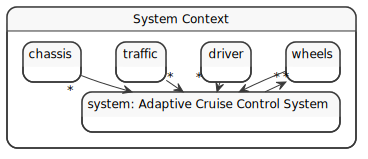

In [55]:
%viz --view=INTERCONNECTION Context::"System Context"

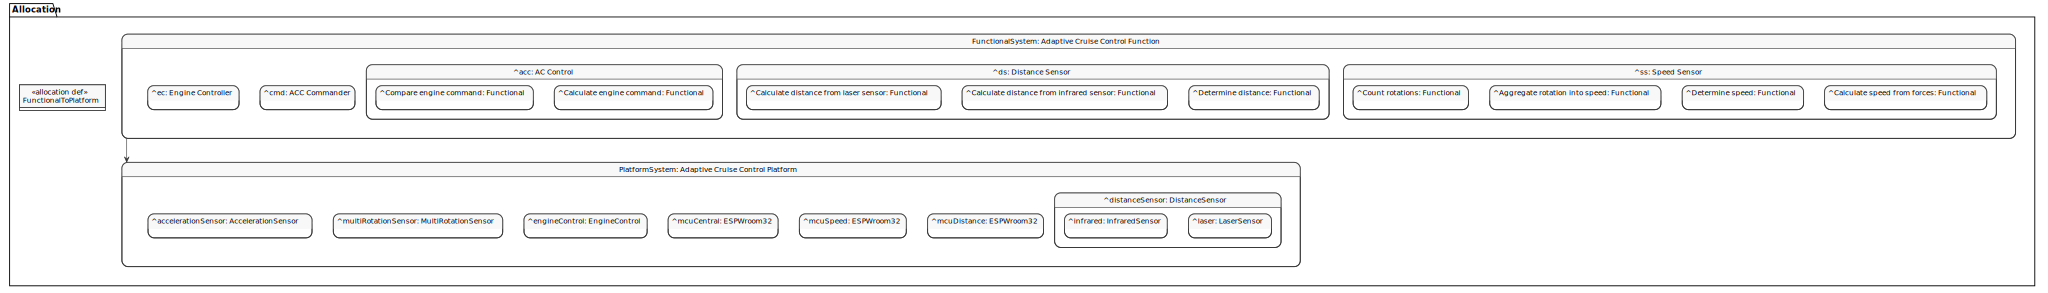

In [56]:
%viz --view=INTERCONNECTION Allocation

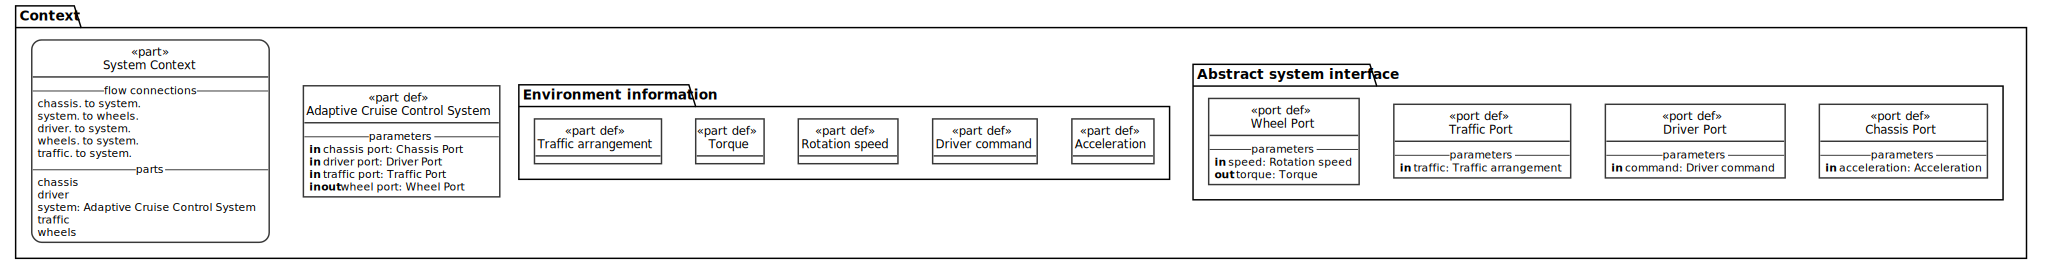

In [57]:
%viz --view=TREE --style=COMPMOST Context

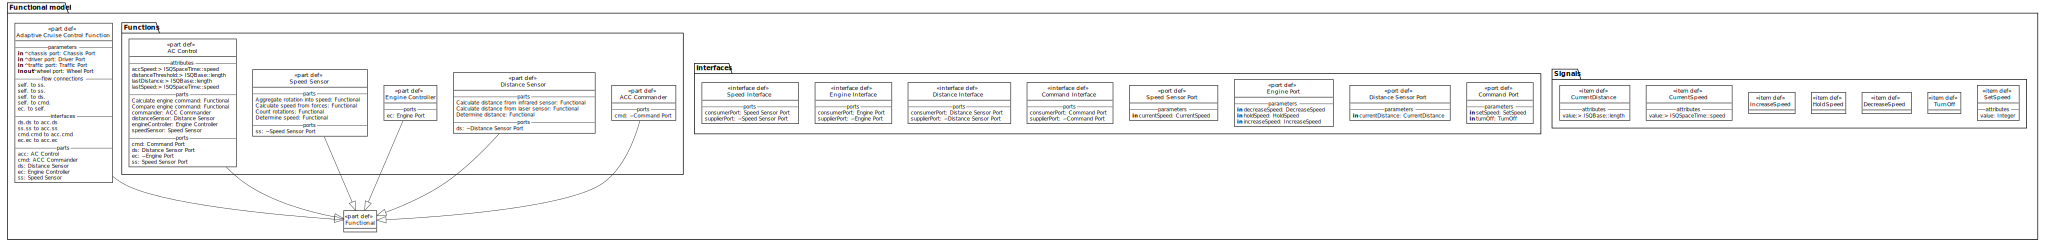

In [63]:
%viz --view=TREE --style=COMPMOST "Functional model"

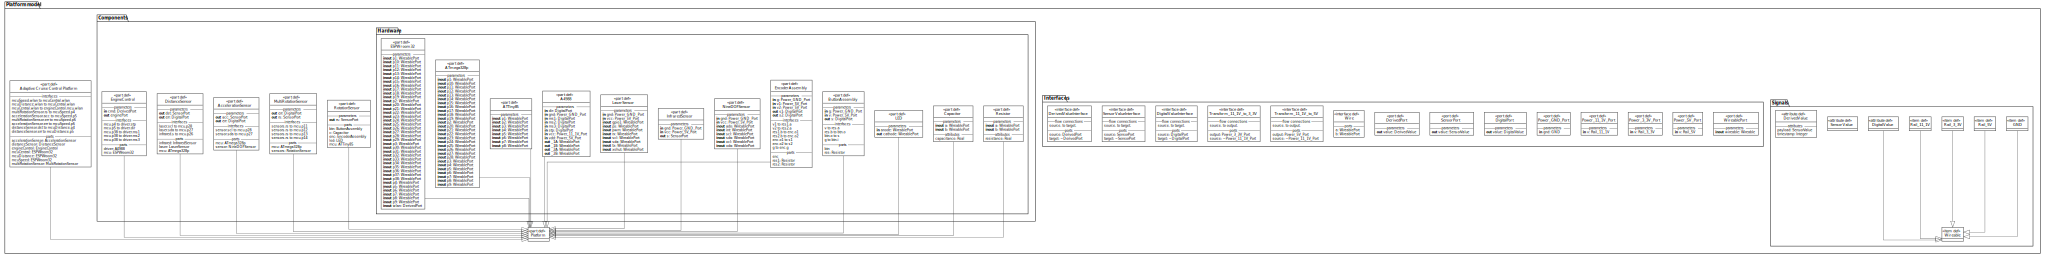

In [70]:
%viz --style=ORTHOLINE --view=TREE --style=COMPMOST --style=TB "Platform model"